# Experiment - Product Propensity - Correlation

* StellarAlgo Data Science
* Peter Morrison
* Nov 22, 2022


Goal: This experiment is to determine the correlation of our features to the target (product).

Actionable Outcome: Apply weights or add/remove features to our model.

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from pycaret.classification import *
from shared_utilities import helpers

In [93]:
CLUSTER = "prod-app"
DATABASE = "stlrcanucks"
LKUPCLIENTID = "7"
SCORING_YEAR = 2022

In [94]:
dataset = helpers.get_product_propensity_dataset(
    cluster=CLUSTER,
    database=DATABASE,
    lkupclientid=LKUPCLIENTID,
    scoring_year=SCORING_YEAR,
    type_flag=0
)

dataset.shape

Authorized as AROASQ4JELIXYLYV6P4UV:pmorrison@stellaralgo.com


(699124, 27)

In [95]:
# choose the features for the stellar base PP model
features = [
    "atp_last",
    "attendedpct_last",
    "attendedpct_prior",
    "attendance_current",
    "attended_last",
    "attended_prior",
    "clientcode",
    "dimcustomermasterid",
    "date_last_save",
    "date_last_send",
    "date_last_touch",
    "events_last",
    "events_prior",
    "distance",
    "events_current",
    "lkupclientid",
    "opens",
    "opens_prior",
    "product",
    "product_current",
    "product_last",
    "seasonyear",
    "sends",
    "sends_prior",
    "spend_current",
    "tenure",
    "volume_current"
]

# copy your main dataframe
df = dataset.copy()

# creating the training and evaluation dataframe
df = df[features]

## Pre-processing

We want to limit the data to what we will actually use. We don't train with "Individual" as a `product` result so we filter it out.

We also want to remove outliers here if we think those will be an issue.

In [96]:
# limiting classes to only product plans
product_plans = ["Full Season", "Half Season", "Quarter", "Mini Pack"]

df = df[df["product"].isin(product_plans)]

## Encoding

We are going to encode our categorical data so its possible to calculate values with it.

We want to see which values look categorical. In this case its the product names.

In [ ]:
pd.set_option('display.max_columns', None)
df.head()

In [ ]:
df["product_encoded"] = df["product"].astype("category").cat.codes
df["product_current_encoded"] = df["product_current"].astype("category").cat.codes
df["product_last_encoded"] = df["product_last"].astype("category").cat.codes

df.head()

## Type Checking/Casting

We want to make sure all types are correct. If an int is stored as a string, it will fail any processing

In [ ]:
df.info()

df["attendedpct_last"] = df["attendedpct_last"].replace(to_replace=[None, "None"], value=np.nan).fillna(value=np.nan).astype(float).astype("float64")
df["attendedpct_prior"] = df["attendedpct_prior"].replace(to_replace=[None, "None"], value=np.nan).fillna(value=np.nan).astype(float).astype("float64")
df["attendance_current"] = df["attendance_current"].replace(to_replace=[None, "None"], value=np.nan).fillna(value=np.nan).astype(float).astype("float64")

df.head()

In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15923 entries, 639 to 699101
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   atp_last                 13323 non-null  float64
 1   attendedpct_last         13323 non-null  float64
 2   attendedpct_prior        15923 non-null  float64
 3   attendance_current       15923 non-null  float64
 4   attended_last            13323 non-null  float64
 5   attended_prior           15923 non-null  int64  
 6   clientcode               15923 non-null  object 
 7   dimcustomermasterid      15923 non-null  int64  
 8   date_last_save           15915 non-null  object 
 9   date_last_send           15608 non-null  object 
 10  date_last_touch          0 non-null      object 
 11  events_last              13323 non-null  float64
 12  events_prior             15923 non-null  int64  
 13  distance                 15923 non-null  float64
 14  events_current     

# Correlation

Here we can check the correlation value of all variables compared to the target

In [143]:
target = "product_encoded"
corr_subset = ["product_current_encoded", "events_current", "events_prior", "events_last", "opens", "sends", "distance", target]

## Full Dataset

We will check on the full dataset, a section on using a subset of columns is after this sub-section. Its large, so minimize this section to jump to the next

In [129]:
corr = df[df.columns].corr()
df[df.columns].corr()[target].sort_values(ascending=False)

product_encoded            1.000000
product_current_encoded    0.567148
product_last_encoded       0.233877
attendedpct_prior         -0.017378
distance                  -0.026667
dimcustomermasterid       -0.052184
seasonyear                -0.057426
volume_current            -0.064628
attendance_current        -0.073534
spend_current             -0.088704
opens_prior               -0.100963
tenure                    -0.165840
opens                     -0.191016
attendedpct_last          -0.213109
sends                     -0.269062
sends_prior               -0.299302
atp_last                  -0.332826
attended_prior            -0.574767
events_prior              -0.594598
attended_last             -0.659340
events_last               -0.700413
events_current            -0.793247
lkupclientid                    NaN
Name: product_encoded, dtype: float64

We can see above, the highest most values are positively correlated (`product_current_encoded` is positively correlated to `product_encoded`) and the lower values are negatively correlated (`events_current` shows a negative correlation).

We can select a subset that we want to check and make sure the correlation isn't different when compared to the whole dataset above

### Heat Maps of Correlation

Text(0.5, 1.0, 'Correlation Heatmap')

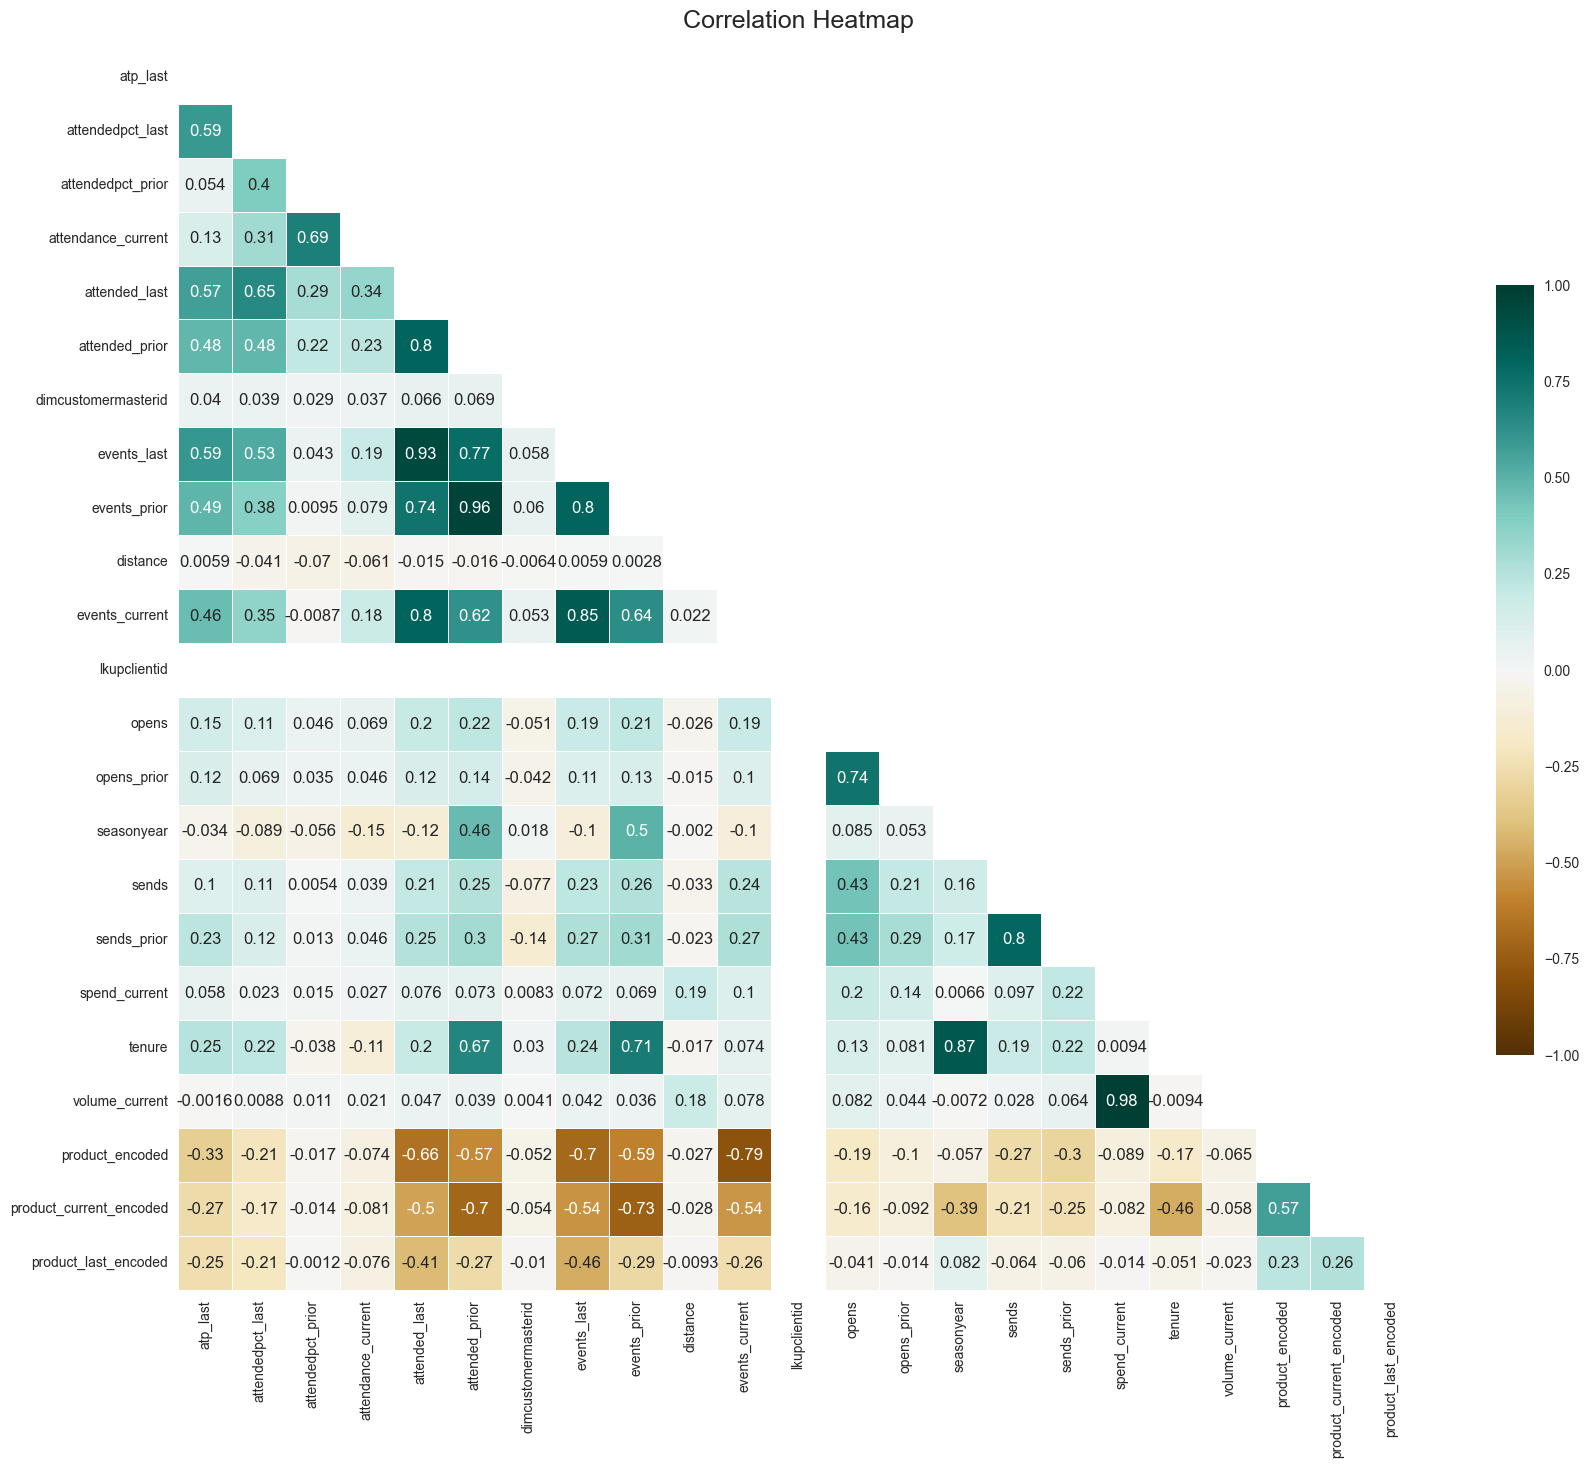

In [102]:
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(20,20))
heatmap = sns.heatmap(corr, cmap='BrBG', mask=mask, vmin=-1, vmax=1, center=0, square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5})
heatmap.set_title(f'Correlation Heatmap', fontdict={'fontsize':18}, pad=16)

Text(0.5, 1.0, 'Features Correlating with product_encoded')

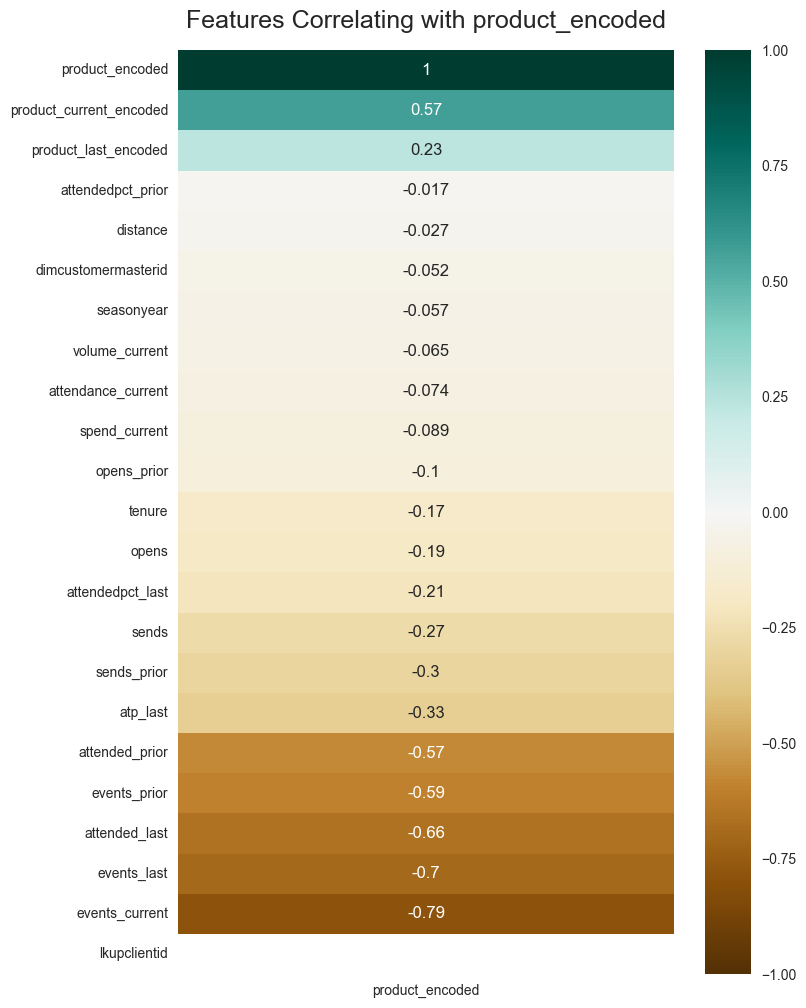

In [103]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[[target]].sort_values(by=target, ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title(f'Features Correlating with {target}', fontdict={'fontsize':18}, pad=16)

## Subset of Columns

In [104]:
corr = df[corr_subset].corr()
df[corr_subset].corr()[target].sort_values(ascending=False)

product_encoded            1.000000
product_current_encoded    0.567148
tenure                    -0.165840
opens                     -0.191016
events_current            -0.793247
Name: product_encoded, dtype: float64

### Charts of Correlation

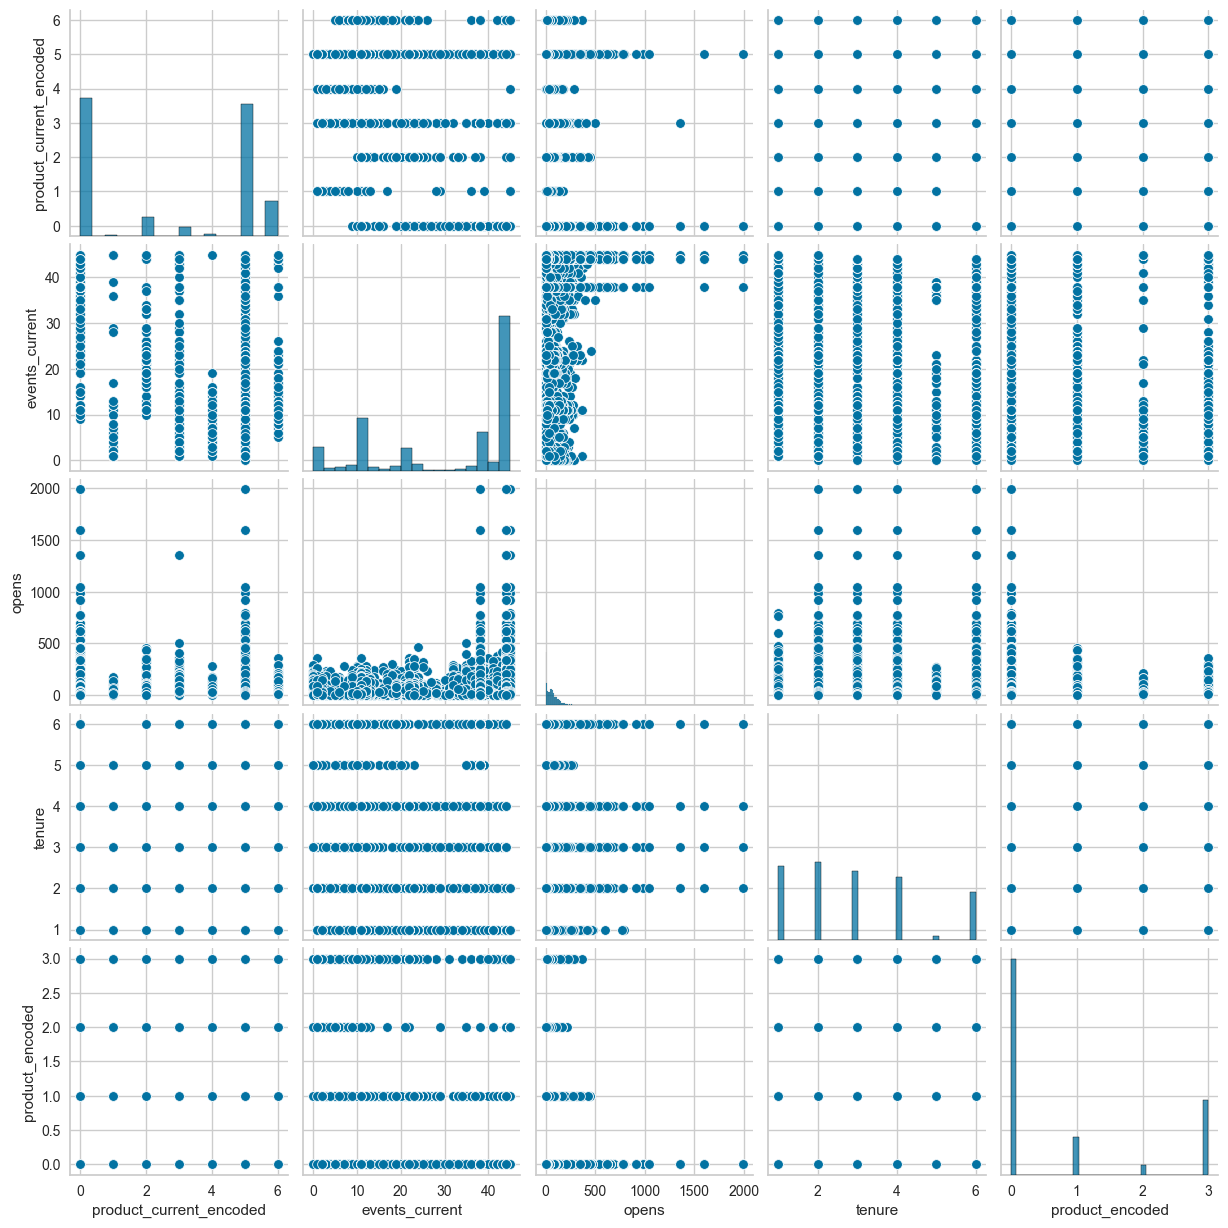

In [105]:
sns.pairplot(df[corr_subset])
plt.show()

<AxesSubplot: >

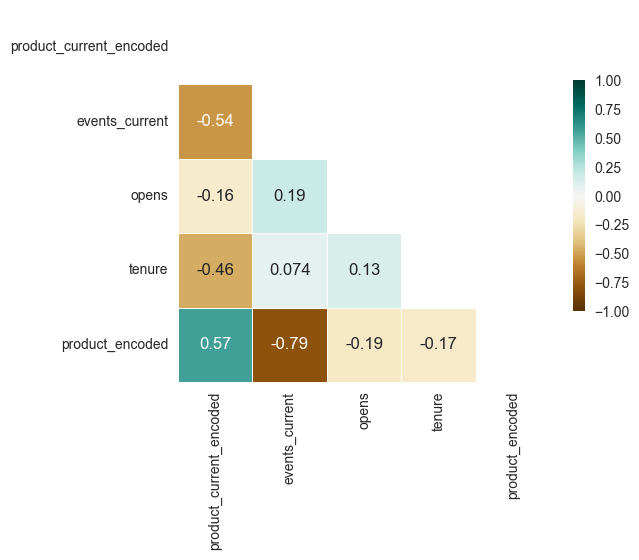

In [106]:
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(6,6))
sns.heatmap(corr, cmap='BrBG', mask=mask, vmin=-1, vmax=1, center=0, square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5})

# Spearman Correlation

We want to determine the correlation using a monotonic function, rather than Pearson which is a linear relationship measure.

This looks better in their example, https://s3.amazonaws.com/s3.stackabuse.com/media/articles/calculating-spearmans-rank-correlation-coefficient-in-python-with-pandas-7.png but hopefully this is valuable to have.

In [156]:
# Credit of this cell goes to https://stackabuse.com/calculating-spearmans-rank-correlation-coefficient-in-python-with-pandas/

def display_correlation(df):
    r = df.corr(method="spearman")
    plt.figure(figsize=(10,6))
    mask = np.triu(np.ones_like(r, dtype=bool))
    heatmap = sns.heatmap(df.corr(), vmin=-1, 
                      vmax=1, annot=True, mask=mask)
    plt.title("Spearman Correlation")
    return(r)

def plot_data_corr(df,title,color="green"):    
    r = display_correlation(df)
    fig, ax = plt.subplots(nrows=1, ncols=len(df.columns)-1,figsize=(14,3))
    for i in range(1,len(df.columns)):
        ax[i-1].scatter(df[target],df.values[:,i],color=color)
        ax[i-1].title.set_text(title[i] +'\n r = ' + 
                             "{:.2f}".format(r.values[0,i]))
        ax[i-1].set(xlabel=df.columns[0],ylabel=df.columns[i])
    fig.subplots_adjust(wspace=.7)    
    plt.show()

def display_corr_pairs(df,color="cyan"):
    s = set_title = np.vectorize(lambda ax,r,rho,ken: ax.title.set_text("spearman = " + 
                                        "{:.2f}".format(r) + 
                                        '\n pearson = ' + 
                                        "{:.2f}".format(rho) +
                                        '\n kendall = ' + 
                                        "{:.2f}".format(ken)) if ax!=None else None
                            )      

    r = display_correlation(df)
    rho = df.corr(method="pearson")
    ken = df.corr(method="kendall")
    g = sns.PairGrid(df,corner=True)
    g.map_diag(plt.hist,color="gold")
    g.map_lower(sns.scatterplot,color="teal")
    set_title(g.axes,r,rho,ken)
    plt.subplots_adjust(hspace = 0.6)
    plt.show()

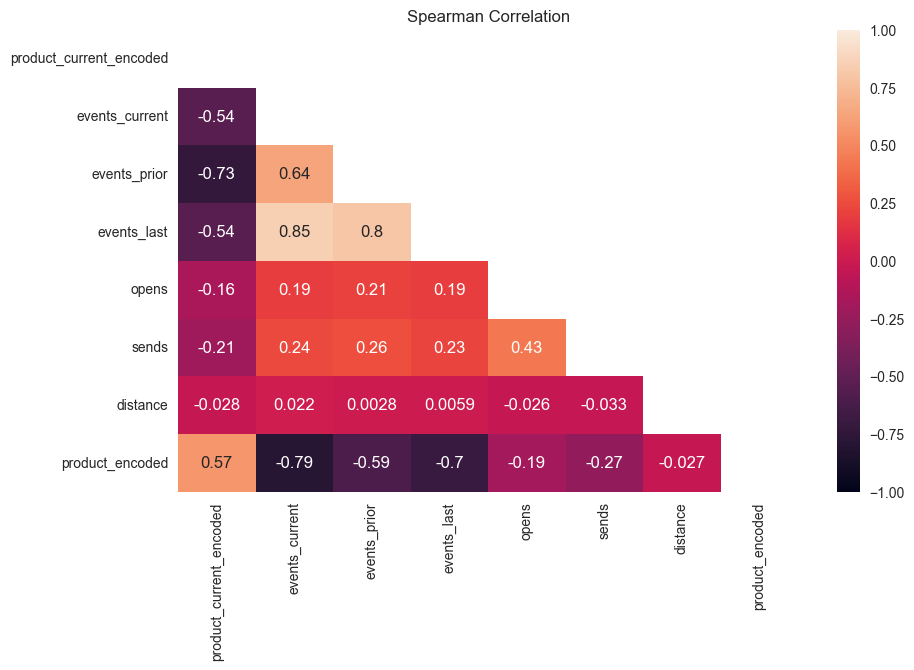

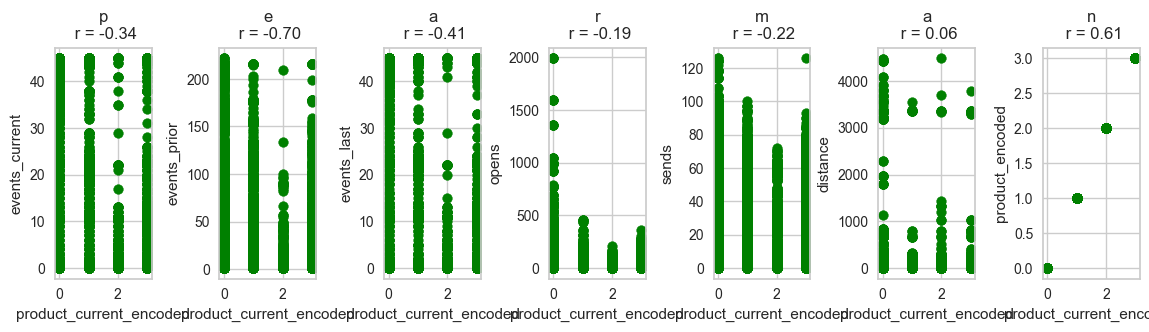

In [154]:
plot_data_corr(df[corr_subset], "Spearman Correlation Test 1")

## Plot Map

Made up the name, but its plots in-place of a heat map.

Rho = Pearson correlation
R = Spearman correlation

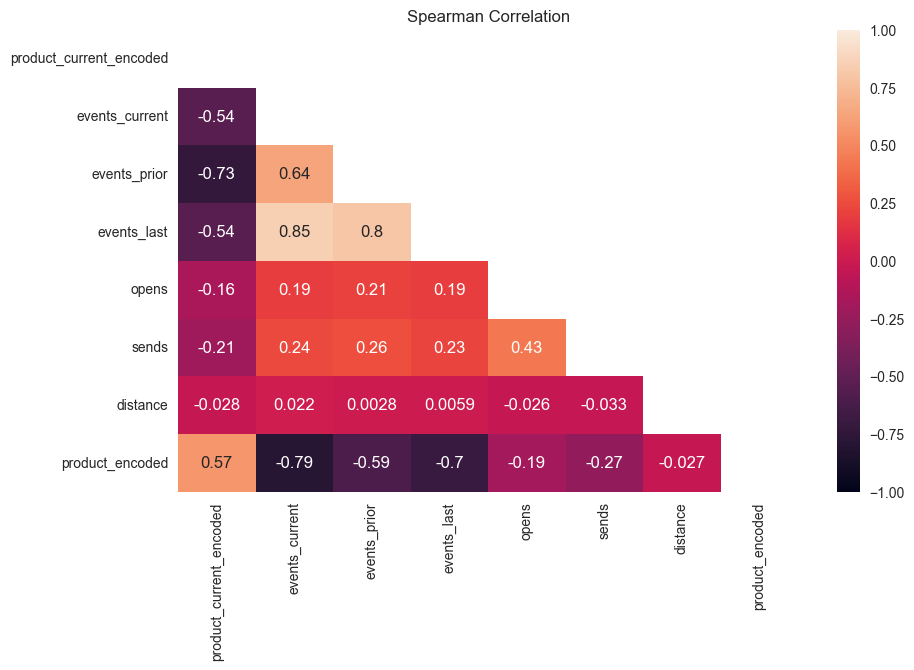

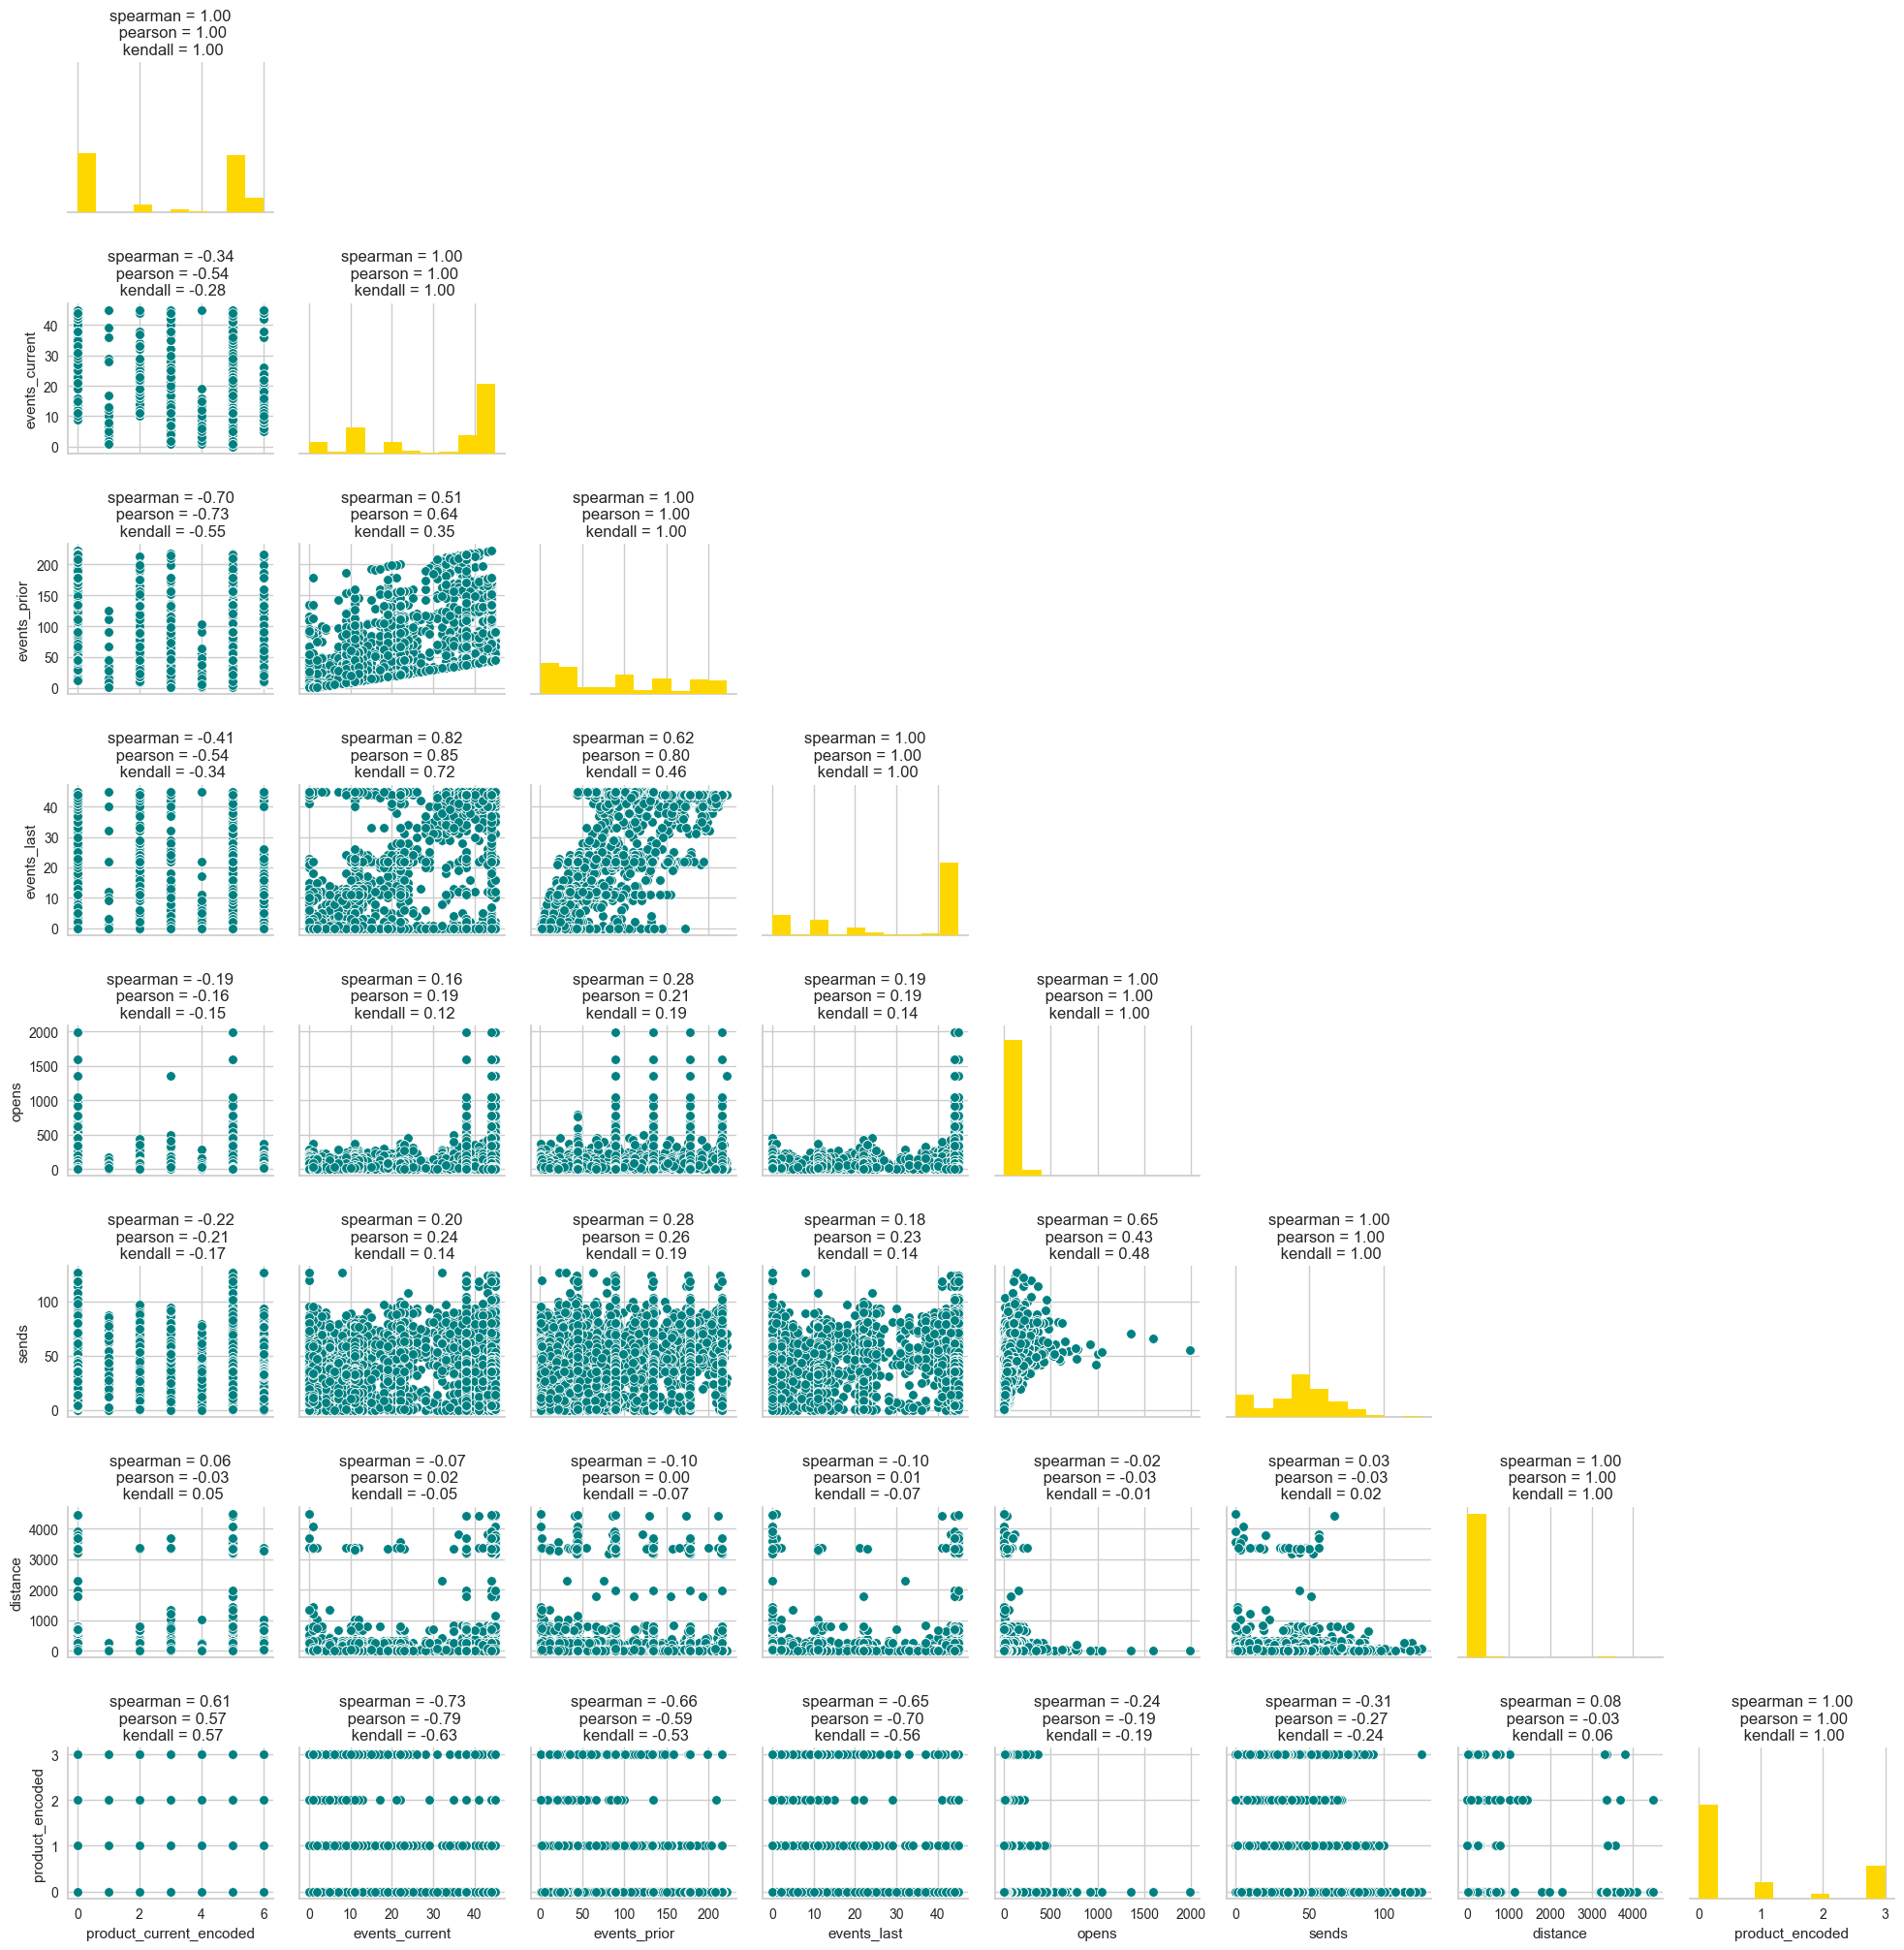

In [157]:
display_corr_pairs(df[corr_subset])